# Cultural Tourism Data Analysis 
### Allison Biediger
***

In [345]:
import pandas as pd

# Load the dataset
df = pd.read_csv("tourism_dataset_5000.csv")

# Display first few rows
df.head()

,Tourist ID,Age,Interests,Preferred Tour Duration,Accessibility,Site Name,Sites Visited,Tour Duration,Route ID,Tourist Rating,System Response Time,Recommendation Accuracy,VR Experience Quality,Satisfaction
0,1,48,"['Architecture', 'Art', 'History']",5,False,Eiffel Tower,"['Eiffel Tower', 'Great Wall of China', 'Taj M...",7,1000,1.6,3.73,97,4.5,3
1,2,37,"['Cultural', 'Nature']",6,False,Colosseum,['Great Wall of China'],1,2000,2.6,2.89,90,4.5,3
2,3,43,"['History', 'Art', 'Architecture']",6,True,Machu Picchu,['Eiffel Tower'],2,3000,1.7,2.22,94,4.7,3
3,4,46,"['Cultural', 'Art', 'Architecture']",8,False,Colosseum,"['Machu Picchu', 'Taj Mahal']",5,4000,2.0,2.34,92,4.7,3
4,5,53,"['Architecture', 'Art']",5,True,Colosseum,"['Machu Picchu', 'Taj Mahal', 'Great Wall of C...",7,5000,3.7,2.00,96,4.8,4


In [347]:
print(df.columns)

Index(['Tourist ID', 'Age', 'Interests', 'Preferred Tour Duration',
       'Accessibility', 'Site Name', 'Sites Visited', 'Tour Duration',
       'Route ID', 'Tourist Rating', 'System Response Time',
       'Recommendation Accuracy', 'VR Experience Quality', 'Satisfaction'],
      dtype='object')


***
## Data prep and model creation

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [352]:
# Convert columns from string to lists 
df['Sites Visited'] = df['Sites Visited'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['Interests'] = df['Interests'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize MultiLabelBinarizer for "Sites Visited"
mlb_sites = MultiLabelBinarizer()
sites_encoded = pd.DataFrame(mlb_sites.fit_transform(df['Sites Visited']), columns=mlb_sites.classes_)

# Initialize MultiLabelBinarizer for "Interests"
mlb_interests = MultiLabelBinarizer()
interests_encoded = pd.DataFrame(mlb_interests.fit_transform(df['Interests']), columns=mlb_interests.classes_)

# Drop original columns and merge the new binary columns
df = df.drop(columns=['Sites Visited', 'Interests']).join([sites_encoded, interests_encoded])

# Display the updated dataframe
print(df.head())


   Tourist ID  Age  Preferred Tour Duration  Accessibility     Site Name  \
0           1   48                        5          False  Eiffel Tower   
1           2   37                        6          False     Colosseum   
2           3   43                        6           True  Machu Picchu   
3           4   46                        8          False     Colosseum   
4           5   53                        5           True     Colosseum   

   Tour Duration  Route ID  Tourist Rating  System Response Time  \
0              7      1000             1.6                  3.73   
1              1      2000             2.6                  2.89   
2              2      3000             1.7                  2.22   
3              5      4000             2.0                  2.34   
4              7      5000             3.7                  2.00   

   Recommendation Accuracy  ...  Colosseum  Eiffel Tower  Great Wall of China  \
0                       97  ...          0           

## Linear Regresion

In [354]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Satisfaction']) 
y = df['Satisfaction'] 

# Identify categorical and numerical columns
categorical_cols = ['Site Name'] 
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Create a preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),  
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  
])

# Define the full model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()) 
])

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model - Mean Absolute Error: {mae:.2f}")
print(f"Model - R² Score: {r2:.2f}")


Model - Mean Absolute Error: 0.33
Model - R² Score: 0.74


### MEA shows a mean average difference of 0.33 satisfaction points. R^2 shows that the model is able to predict correctly about 74% of the time. 

***
## Feature Importance Analysis

In [359]:
# Get numerical and categorical feature names
num_features = numerical_cols
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine both sets of feature names
all_feature_names = list(num_features) + list(cat_features)

# Get model coefficients
coefficients = model.named_steps['regressor'].coef_

# Ensure feature and coefficient lengths match
if len(all_feature_names) != len(coefficients):
    print(f"Feature count mismatch: {len(all_feature_names)} features vs. {len(coefficients)} coefficients")
else:
    # Combine feature names and absolute importance values
    feature_importance = dict(zip(all_feature_names, np.abs(coefficients)))

    # Sort by importance (descending)
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    # Print feature importance
    print("Feature Importance (sorted by absolute value):")
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")


Feature Importance (sorted by absolute value):
Tourist Rating: 0.6211
Taj Mahal: 0.0128
Eiffel Tower: 0.0126
Cultural: 0.0111
Recommendation Accuracy: 0.0111
Machu Picchu: 0.0099
History: 0.0081
Art: 0.0066
Nature: 0.0065
Tourist ID: 0.0063
Route ID: 0.0063
Great Wall of China: 0.0061
Age: 0.0060
Site Name_Great Wall of China: 0.0047
Site Name_Eiffel Tower: 0.0042
Preferred Tour Duration: 0.0021
Architecture: 0.0021
VR Experience Quality: 0.0014
Site Name_Taj Mahal: 0.0012
Site Name_Colosseum: 0.0011
Tour Duration: 0.0009
Site Name_Machu Picchu: 0.0005
System Response Time: 0.0004
Colosseum: 0.0002


***
## Visualization Creation

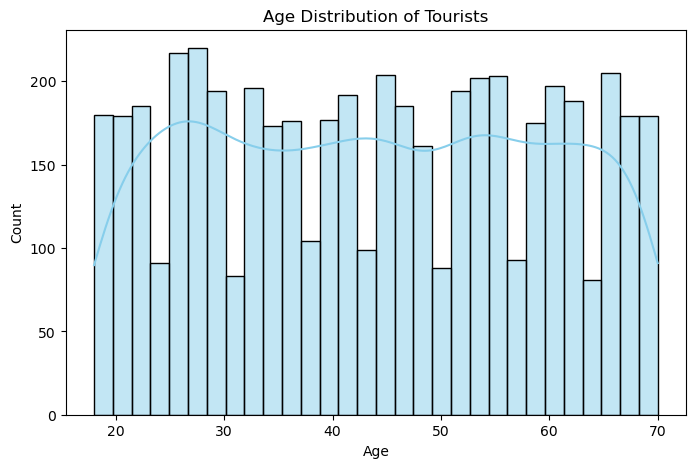

In [362]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=30, kde=True, color="skyblue")
plt.title("Age Distribution of Tourists")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

### Well spread age ranges from 18 - 70 years old.

C:\Users\flyer\AppData\Local\Temp\ipykernel_14444\1627015449.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=site_visits.values, y=site_visits.index, palette="coolwarm")


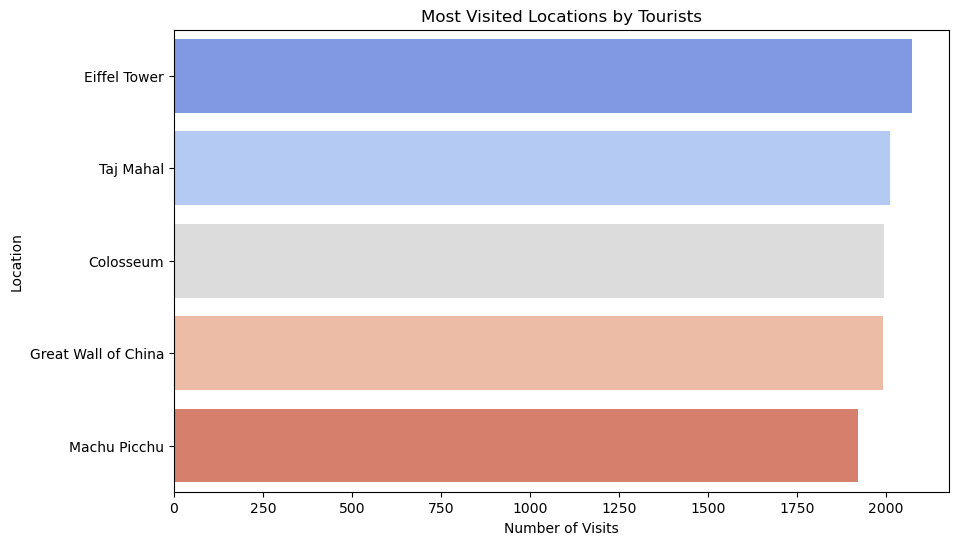

In [364]:
# Sum the occurrences of each site
site_visits = df[['Colosseum', 'Eiffel Tower', 'Great Wall of China', 'Machu Picchu', 'Taj Mahal']].sum().sort_values(ascending=False)

# Plot the most visited locations
plt.figure(figsize=(10, 6))
sns.barplot(x=site_visits.values, y=site_visits.index, palette="coolwarm")
plt.xlabel("Number of Visits")
plt.ylabel("Location")
plt.title("Most Visited Locations by Tourists")
plt.show()

C:\Users\flyer\AppData\Local\Temp\ipykernel_14444\1018129905.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=site_visits.values, y=site_visits.index, palette="coolwarm")


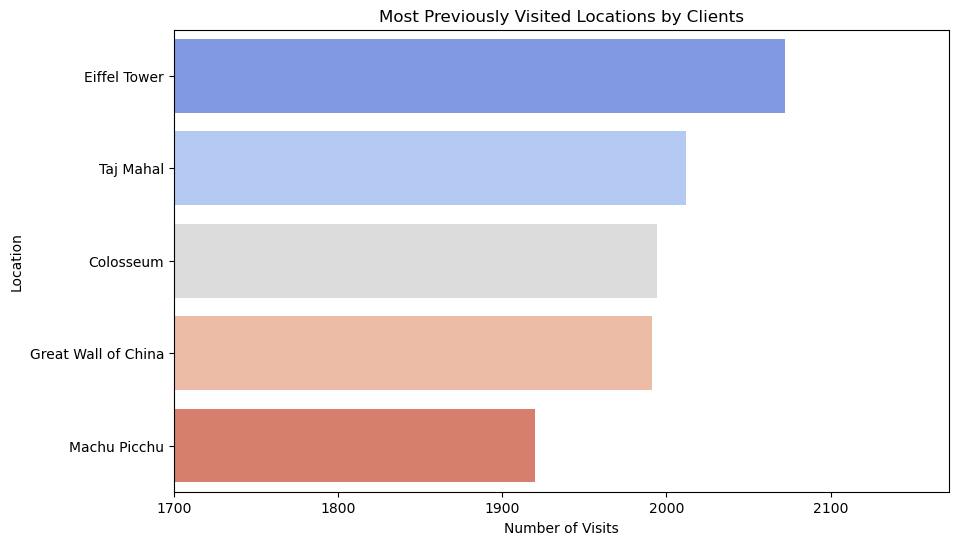

In [366]:
# Sum the occurrences of each site
site_visits = df[['Colosseum', 'Eiffel Tower', 'Great Wall of China', 'Machu Picchu', 'Taj Mahal']].sum().sort_values(ascending=False)

# Plot the most visited locations
plt.figure(figsize=(10, 6))
sns.barplot(x=site_visits.values, y=site_visits.index, palette="coolwarm")

# Set x-axis limits starting from 1700
plt.xlim(1700, site_visits.max() + 100)  

plt.xlabel("Number of Visits")
plt.ylabel("Location")
plt.title("Most Previously Visited Locations by Clients")

plt.show()

C:\Users\flyer\AppData\Local\Temp\ipykernel_14444\1910928718.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_visits.values, y=category_visits.index, palette="viridis")


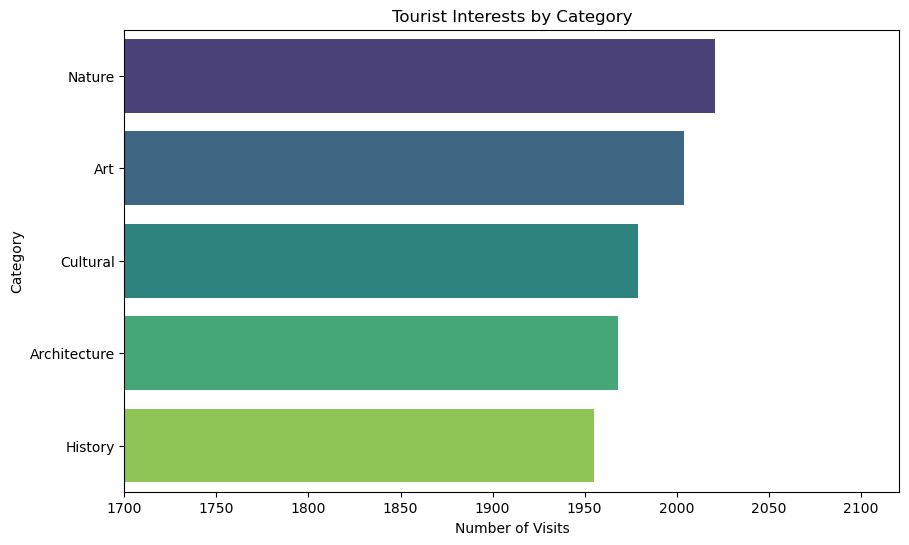

In [367]:
# Sum the occurrences for each category
category_visits = df[['Architecture', 'Art', 'Cultural', 'History', 'Nature']].sum().sort_values(ascending=False)

# Plot the most visited categories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_visits.values, y=category_visits.index, palette="viridis")

# Set x-axis limits starting from 1700
plt.xlim(1700, category_visits.max() + 100) 

plt.xlabel("Number of Visits")
plt.ylabel("Category")
plt.title("Tourist Interests by Category")

plt.show()


C:\Users\flyer\AppData\Local\Temp\ipykernel_14444\2563966569.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accessibility_counts.index, y=accessibility_counts.values, palette="Blues")


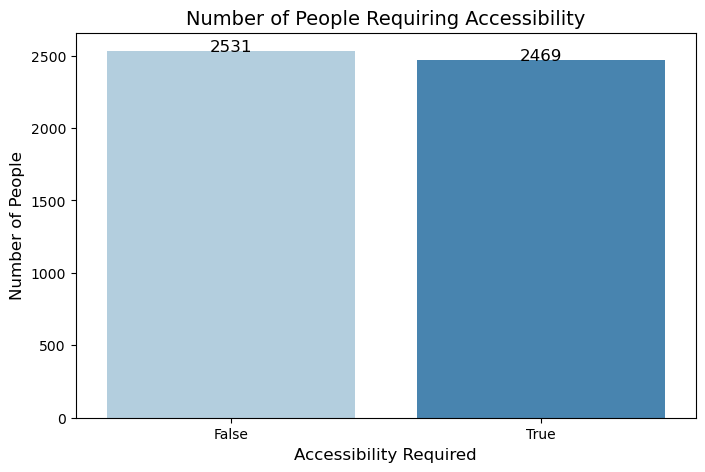

In [369]:
# Count the number of people needing accessibility
accessibility_counts = df['Accessibility'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=accessibility_counts.index, y=accessibility_counts.values, palette="Blues")

# Add labels and title
plt.xlabel("Accessibility Required", fontsize=12)
plt.ylabel("Number of People", fontsize=12)
plt.title("Number of People Requiring Accessibility", fontsize=14)

# Show values on top of bars
for i, value in enumerate(accessibility_counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)

# Show plot
plt.xticks(ticks=[0, 1], labels=["False", "True"])  
plt.show()
